C:\Users\anjan\AppData\Local\Temp\ipykernel_12196\3488513663.py:53: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  summary['Best Side'] = merged_df.groupby('classification').apply(best_side)
C:\Users\anjan\AppData\Local\Temp\ipykernel_12196\3488513663.py:59: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  summary['Top Coin'] = merged_df.groupby('classification').apply(top_coin)


===== SUMMARY TABLE =====
                Average PnL  Number of Trades Best Side Top Coin
classification                                                  
Extreme Fear      34.537862             21400      SELL     PNUT
Extreme Greed     67.892861             39992      SELL   PEOPLE
Fear              54.290400             61837       BUY      SEI
Greed             42.743559             50303      SELL     @109
Neutral           34.307718             37686      SELL     DOGE


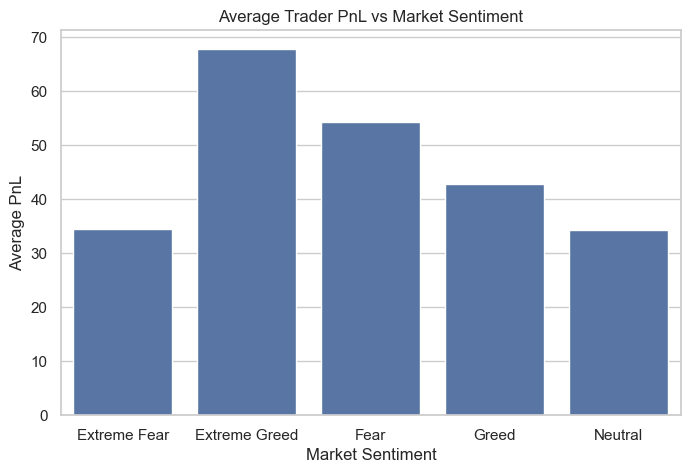

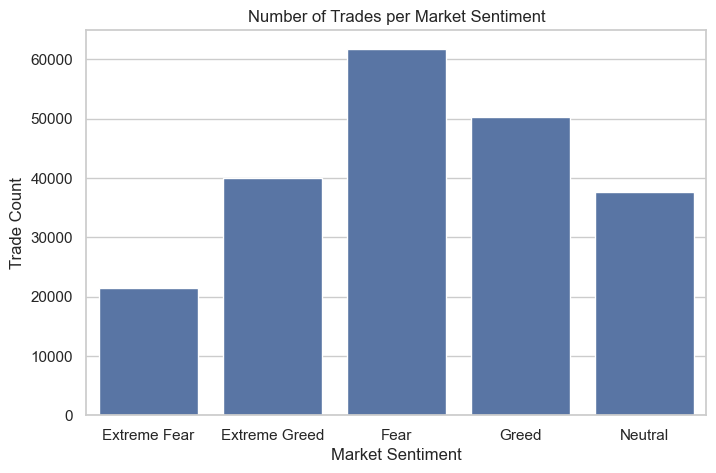

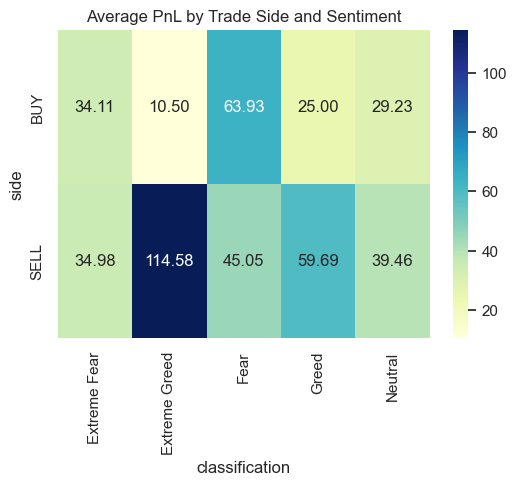

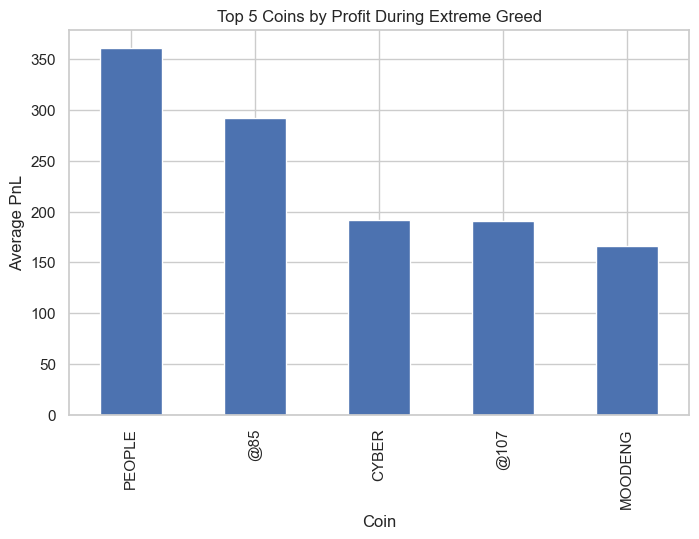

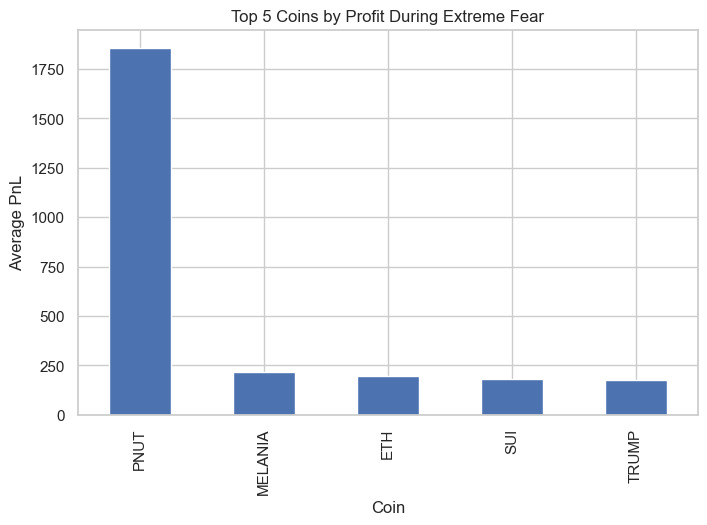

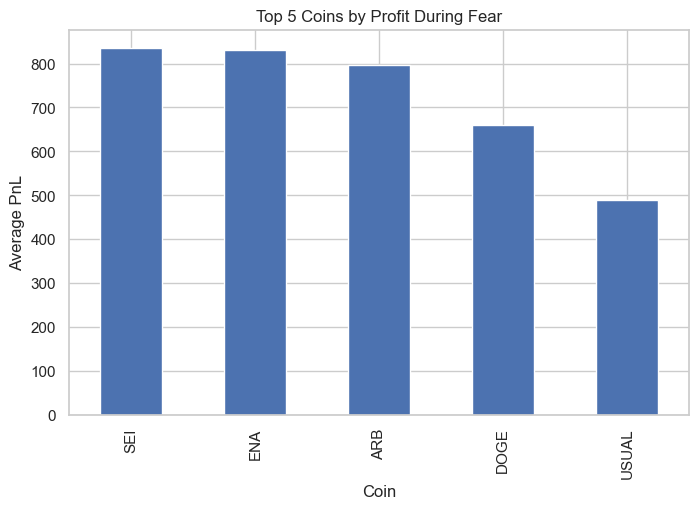

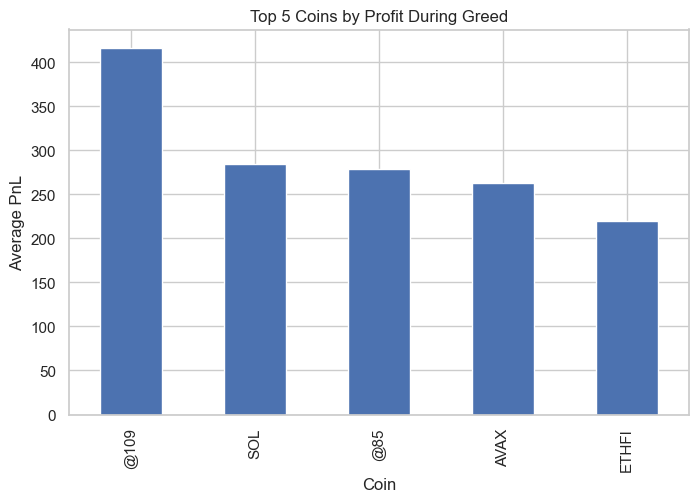

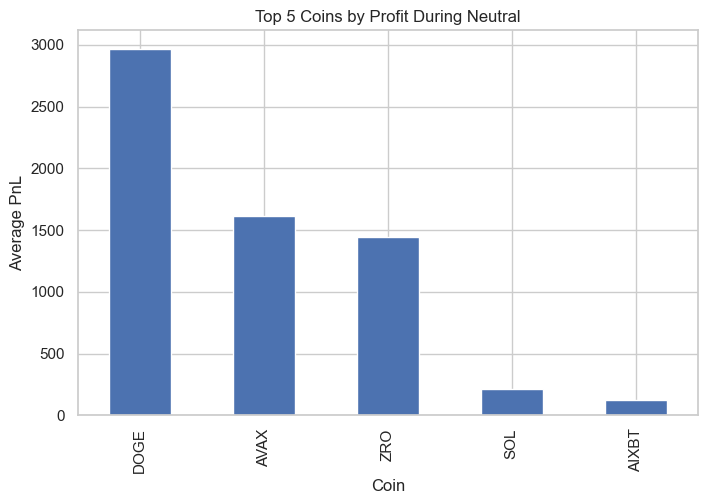

✅ Analysis completed successfully!


In [61]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# ===============================
# 1️⃣ Load Fear/Greed Index Data
# ===============================
sentiment_file = "data/Fear_Greed_Index.csv"
sentiment_df = pd.read_csv(sentiment_file)

sentiment_df.columns = sentiment_df.columns.str.strip().str.lower()
sentiment_df['date'] = pd.to_datetime(sentiment_df['date'], errors='coerce').dt.date

# ===============================
# 2️⃣ Load Historical Trader Data
# ===============================
trader_file = "data/Historical_Data.csv"
trader_df = pd.read_csv(trader_file)

trader_df.columns = trader_df.columns.str.strip().str.lower()
trader_df['time'] = pd.to_datetime(
    trader_df['timestamp ist'],
    format='%d-%m-%Y %H:%M',
    errors='coerce'
)
trader_df['date'] = trader_df['time'].dt.date

# Keep only relevant columns
trader_df = trader_df[
    ['account', 'coin', 'size tokens', 'side', 'time', 'closed pnl', 'date']
]

# ===============================
# 3️⃣ Merge Datasets on Date
# ===============================
merged_df = pd.merge(trader_df, sentiment_df, on='date', how='left')

# ===============================
# 4️⃣ Summary Metrics
# ===============================
summary = pd.DataFrame()

# Average PnL per sentiment
summary['Average PnL'] = merged_df.groupby('classification')['closed pnl'].mean()

# Number of trades per sentiment
summary['Number of Trades'] = merged_df.groupby('classification').size()

# Best trade side per sentiment
def best_side(df):
    return df.groupby('side')['closed pnl'].mean().idxmax()

summary['Best Side'] = merged_df.groupby('classification').apply(best_side)

# Top coin per sentiment
def top_coin(df):
    return df.groupby('coin')['closed pnl'].mean().idxmax()

summary['Top Coin'] = merged_df.groupby('classification').apply(top_coin)

print("===== SUMMARY TABLE =====")
print(summary)

# ===============================
# 5️⃣ Visualizations
# ===============================
sns.set(style="whitegrid")

# Average PnL vs Sentiment
plt.figure(figsize=(8, 5))
sns.barplot(x=summary.index, y=summary['Average PnL'].values)
plt.title("Average Trader PnL vs Market Sentiment")
plt.ylabel("Average PnL")
plt.xlabel("Market Sentiment")
plt.savefig("Average_PnL_vs_Sentiment.png")
plt.show()

# Number of trades per sentiment
plt.figure(figsize=(8, 5))
sns.barplot(x=summary.index, y=summary['Number of Trades'].values)
plt.title("Number of Trades per Market Sentiment")
plt.ylabel("Trade Count")
plt.xlabel("Market Sentiment")
plt.savefig("Trades_Count_vs_Sentiment.png")
plt.show()

# Buy/Sell performance heatmap
pivot_side = merged_df.pivot_table(
    index='side',
    columns='classification',
    values='closed pnl',
    aggfunc='mean'
)

plt.figure(figsize=(6, 4))
sns.heatmap(pivot_side, annot=True, fmt=".2f", cmap="YlGnBu")
plt.title("Average PnL by Trade Side and Sentiment")
plt.savefig("Side_vs_Sentiment_Heatmap.png")
plt.show()

# Top 5 coins per sentiment
for sentiment in merged_df['classification'].dropna().unique():
    top_coins = (
        merged_df[merged_df['classification'] == sentiment]
        .groupby('coin')['closed pnl']
        .mean()
        .sort_values(ascending=False)
        .head(5)
    )

    plt.figure(figsize=(8, 5))
    top_coins.plot(kind='bar')
    plt.title(f"Top 5 Coins by Profit During {sentiment}")
    plt.ylabel("Average PnL")
    plt.xlabel("Coin")
    plt.savefig(f"Top_5_Coins_{sentiment}.png")
    plt.show()

# ===============================
# 6️⃣ Save Final Merged Dataset
# ===============================
merged_df.to_csv("Merged_Trader_Sentiment_Analysis.csv", index=False)

print("✅ Analysis completed successfully!")
